In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation

Dobbiamo definire due classi separate una per l'agente e una per il modello con al suo interno un certo numero di agenti.
Ogni run del modello conterrà diverse istanze del nostro agente inizialmente definito, nel nostro caso ogni agente ha solo una variabile: la richezza che ha a disposizione

In [2]:
class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        
    def step(self): 
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        #1.print ("Hi, I am agent " + str(self.unique_id) +" my wealth is "+str(self.wealth))
        #2. Ora impostiamo una vera e propria azione:se ho denaro da spendere lo da ad un'altro agente in maniera random: utiliziamo
        #model.random perchè così il seed viene fissato all'inizio della simulazione
         if self.wealth == 0:
            return
         other_agent = self.random.choice(self.model.schedule.agents)
         other_agent.wealth += 1
         self.wealth -= 1
       

    
        

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
#Ora dobbiamo aggiungere una funzione di sheduling che ci permetta  di far avanzare il tempo nel modello
    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

Ogni agente deve avere al suo interno un metodo step, che descrive le azioni che facciamo fare una prima run del nostro modello, in questo caso il modello non farà niente ma allocherà solo gli agenti, e restituirà la richezza di ognuno

In [3]:
# Da eseguire con la funzione 1. non commentata in agent step
#empty_model = MoneyModel(10)
#empty_model.step()

In [4]:
#Da eseguire con la funzione 2. non commentata
model = MoneyModel(10)
for i in range(10):
    model.step()

(array([4., 0., 4., 0., 0., 1., 0., 0., 0., 1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

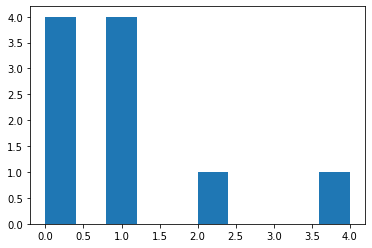

In [5]:
%matplotlib inline

# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

Dopo essermi ricordato come funziona python, posso riscrivere tutto diversificando i casi...
Ora mettiamo gli agenti su una griglia

In [6]:
from mesa.space import MultiGrid

MultiGrid ci permette di lavorare con più agenti in una singola casella, inoltre dotiamo l'agente di più comportamenti, uno per muoversi, uno per scambiare soldi se hanno più ricchezza disponibile

In [7]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

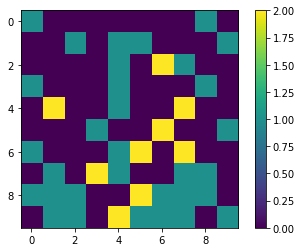

In [8]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()
    
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()



So far, at the end of every model run, we’ve had to go and write our own code to get the data out of the model. This has two problems: it isn’t very efficient, and it only gives us end results. If we wanted to know the wealth of each agent at each step, we’d have to add that to the loop of executing steps, and figure out some way to store the data.

Since one of the main goals of agent-based modeling is generating data for analysis, Mesa provides a class which can handle data collection and storage for us and make it easier to analyze.

The data collector stores three categories of data: model-level variables, agent-level variables, and tables (which are a catch-all for everything else). Model- and agent-level variables are added to the data collector along with a function for collecting them. Model-level collection functions take a model object as an input, while agent-level collection functions take an agent object as an input. Both then return a value computed from the model or each agent at their current state. When the data collector’s collect method is called, with a model object as its argument, it applies each model-level collection function to the model, and stores the results in a dictionary, associating the current value with the current step of the model. Similarly, the method applies each agent-level collection function to each agent currently in the schedule, associating the resulting value with the step of the model, and the agent’s unique_id.

Let’s add a DataCollector to the model, and collect two variables. At the agent level, we want to collect every agent’s wealth at every step. At the model level, let’s measure the model’s Gini Coefficient, a measure of wealth inequality.

In [9]:
from mesa.datacollection import DataCollector

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [10]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

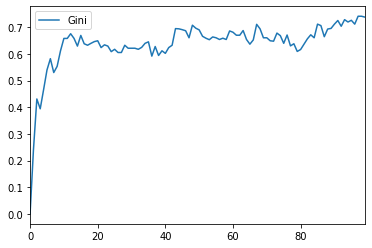

In [11]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [12]:

agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

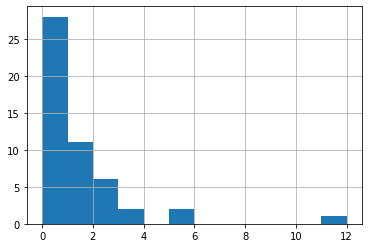

In [13]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

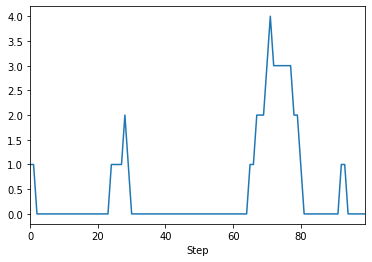

In [14]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

In [15]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [16]:
from mesa.batchrunner import BatchRunner
fixed_params = {"width": 10,
               "height": 10}
variable_params = {"N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini}, display_progress=False)
batch_run.run_all()


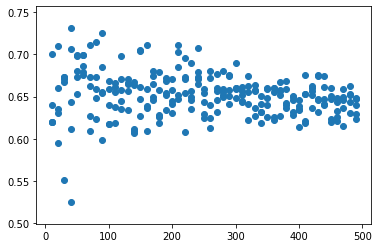

In [17]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)

In [18]:
#Get the Agent DataCollection
data_collector_agents = batch_run.get_collector_agents()

data_collector_agents[(10,2)]

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1
...              ...
99   5             3
     6             0
     7             0
     8             0
     9             0

[1000 rows x 1 columns]

In [19]:
#Get the Model DataCollection.

data_collector_model = batch_run.get_collector_model()

data_collector_model[(10,1)]

,Gini
0,0.00
1,0.00
2,0.00
3,0.00
4,0.32
...,...
95,0.54
96,0.54
97,0.58
98,0.58


In [20]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

Now we create and launch the actual server. We do this with the following arguments:

The model class we’re running and visualizing; in this case, MoneyModel.

A list of module objects to include in the visualization; here, just [grid]

The title of the model: “Money Model”

Any inputs or arguments for the model itself. In this case, 100 agents, and height and width of 10.

Once we create the server, we set the port for it to listen on (you can treat this as just a piece of the URL you’ll open in the browser). Finally, when you’re ready to run the visualization, use the server’s launch() method.

In [21]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
import nest_asyncio
nest_asyncio.apply()


In [22]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "red",
                 "r": 0.5}
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(MoneyModel,
                       [grid],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521
Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"t

{"type":"get_step","step":205}
{"type":"get_step","step":206}
{"type":"get_step","step":207}
{"type":"get_step","step":208}
{"type":"get_step","step":209}
{"type":"get_step","step":210}
{"type":"get_step","step":211}
{"type":"get_step","step":212}
{"type":"get_step","step":213}
{"type":"get_step","step":214}
{"type":"get_step","step":215}
{"type":"get_step","step":216}
{"type":"get_step","step":217}
{"type":"get_step","step":218}
{"type":"get_step","step":219}
{"type":"get_step","step":220}
{"type":"get_step","step":221}
{"type":"get_step","step":222}
{"type":"get_step","step":223}
{"type":"get_step","step":224}
{"type":"get_step","step":225}
{"type":"get_step","step":226}
{"type":"get_step","step":227}
{"type":"get_step","step":228}
{"type":"get_step","step":229}
{"type":"get_step","step":230}
{"type":"get_step","step":231}
{"type":"get_step","step":232}
{"type":"get_step","step":233}
{"type":"get_step","step":234}
{"type":"get_step","step":235}
{"type":"get_step","step":236}
{"type":

{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
Socket opened!
{"type":"reset"}
{"type":"reset"}


KeyboardInterrupt: 